In [1]:
import axelrod as axl
import csv
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
import copy
%matplotlib inline
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Creating our data set

Generating all the random tournaments and saving to [data.csv](data.csv).

In [2]:
test_strategies = [axl.EvolvedLookerUp, axl.TitForTat, axl.Cooperator, axl.Defector, axl.DoubleCrosser]
strategies = [s() for s in axl.strategies if axl.obey_axelrod(s) and s not in test_strategies] 

In [3]:
len(strategies)

103

In [4]:
def rank(strategies, test_strategy=axl.EvolvedLookerUp, repetitions=10, processes=None):
    """Return the rank of the test_strategy in a tournament with given strats"""
    strategies.append(test_strategy())
    tournament = axl.Tournament(strategies, repetitions=repetitions, processes=-1)
    results = tournament.play()
    return results.ranking[-1], results.wins[-1]

Actually running the experiments (this takes a while).

In [18]:
max_size = 26  # Max size of tournaments considered
tournaments = min(max_size - 1, 30)  # Number of tournaments of each size to run
repetitions = 10  # Number of repetitions of each tournament 

In [ ]:
f_lookerup = open('data-lookerup.csv', 'w')
csvwrtr_lookerup = csv.writer(f_lookerup)
f_titfortat = open('data-titfortat.csv', 'w')
csvwrtr_titfortat = csv.writer(f_titfortat)
f_cooperator = open('data-cooperator.csv', 'w')
csvwrtr_cooperator = csv.writer(f_cooperator)
f_defector = open('data-defector.csv', 'w')
csvwrtr_defector = csv.writer(f_defector)
f_doublcrosser = open('data-doublecrosser.csv', 'w')
csvwrtr_doublcrosser = csv.writer(f_doublcrosser)

data_lookerup = []
data_titfortat = []
data_cooperator = []
data_defector = []
data_doublecrosser = []

for size in range(1, max_size):
    
    row_lookerup = [size]
    row_titfortat = [size]
    row_cooperator = [size]
    row_defector = [size]
    row_doublecrosser = [size]

    for k in range(tournaments):
        
        s = random.sample(strategies, size)
        strategy_labels = ";".join([str(st) for st in s])
        
        row_lookerup.append([strategy_labels, rank(copy.copy(s), test_strategy=axl.EvolvedLookerUp, repetitions=repetitions)])
        row_titfortat.append([strategy_labels, rank(copy.copy(s), test_strategy=axl.TitForTat, repetitions=repetitions)])
        row_cooperator.append([strategy_labels, rank(copy.copy(s), test_strategy=axl.Cooperator, repetitions=repetitions)])
        row_defector.append([strategy_labels, rank(copy.copy(s), test_strategy=axl.Defector, repetitions=repetitions)])
        row_doublecrosser.append([strategy_labels, rank(copy.copy(s), test_strategy=axl.DoubleCrosser, repetitions=repetitions)])
     

    data_lookerup.append(row_lookerup)
    csvwrtr_lookerup.writerow(row_lookerup)
    
    data_titfortat.append(row_titfortat)
    csvwrtr_titfortat.writerow(row_titfortat)
    
    data_cooperator.append(row_cooperator)
    csvwrtr_cooperator.writerow(row_cooperator)
    
    data_defector.append(row_defector)
    csvwrtr_defector.writerow(row_defector)
    
    data_doublecrosser.append(row_doublecrosser)
    csvwrtr_doublcrosser.writerow(row_doublecrosser)
    
f_lookerup.close()
f_titfortat.close()
f_cooperator.close()
f_defector.close()
f_doublcrosser.close()

## Analysing the data

Now to analyse the results.

In [19]:
def make_df(row, df):
    data = []
    for ele in list(df.ix[row,1:]):
        data.append([eval(ele)[0].split(";")] + list(eval(ele)[1]))
    return pandas.DataFrame(data, columns=["Strategies", "Rank", "Wins"])

In [72]:
def make_rank_plot(df, filename):
    """Function to plot rank"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Rank")
    mean_rank = np.mean([d["Rank"] for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_rank))
    return plt.boxplot([d["Rank"] for d in df["Data"]])

def make_proportional_rank_plot(df, filename):
    """Function to plot normalised rank"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Proportional rank")
    mean_prop_rank = np.mean([d["Rank"] / (len(d["Strategies"][0])) for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_prop_rank))
    return plt.boxplot([d["Rank"] / (len(d["Strategies"][0])) for d in df["Data"]])

def make_wins_plot(df, filename):
    """Function to plot wins"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Wins")
    mean_wins = np.mean([np.mean([np.mean(r) / 2 for r in d["Wins"]]) for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_wins))
    return plt.boxplot([[np.mean(r) / 2 for r in d["Wins"]] for d in df["Data"]])

def make_proportional_wins_plot(df, filename):
    """Function to plot normalised wins"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Proportional wins")
    mean_prop_wins = np.mean([np.mean([np.mean(r) / 2 / (len(d["Strategies"][0])) for r in d["Wins"]]) for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_prop_wins))
    return plt.boxplot([[np.mean(r) / 2 / (len(d["Strategies"][0])) for r in d["Wins"]] for d in df["Data"]])

In [73]:
def read_data_and_plot(data_file, tournaments=tournaments):
    #raw_df = pandas.read_csv(data_file, header=None, names=["Number of strategies"] + range(1, tournaments + 1))
    raw_df = pandas.read_csv(data_file, header=None, names=["Number of strategies"] + range(1, 31))

    df = pandas.DataFrame([[row + 3, make_df(row, raw_df)] for row in range(len(raw_df))], columns=["Strategies", "Data"])

    make_rank_plot(df, data_file);
    make_proportional_rank_plot(df, data_file);
    make_wins_plot(df, data_file);
    make_proportional_wins_plot(df, data_file);


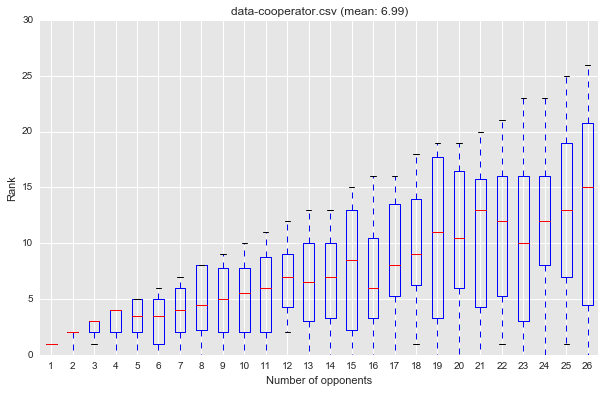

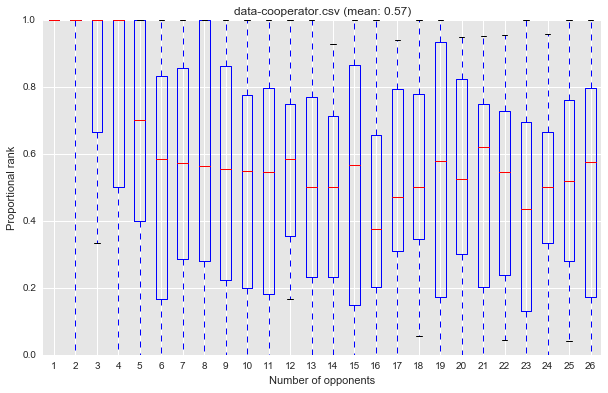

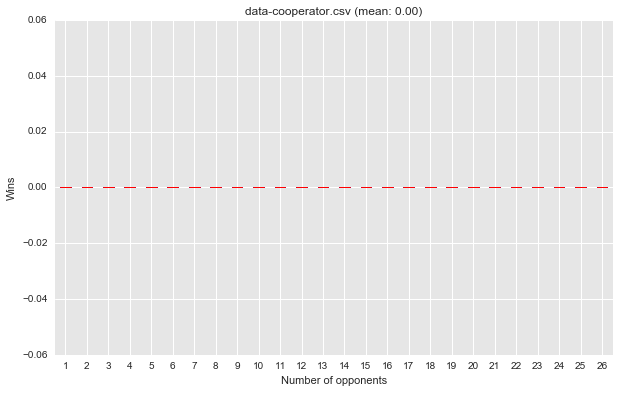

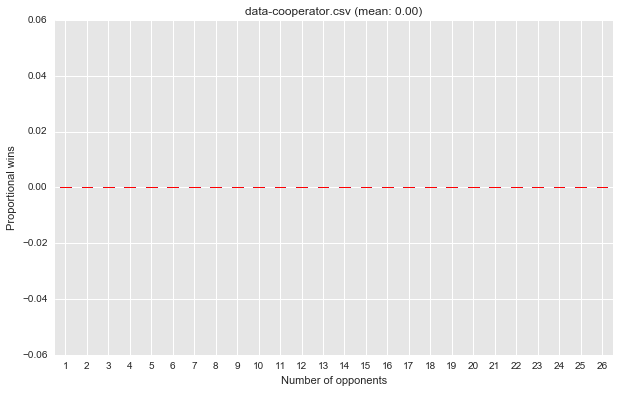

In [74]:
read_data_and_plot("data-cooperator.csv")

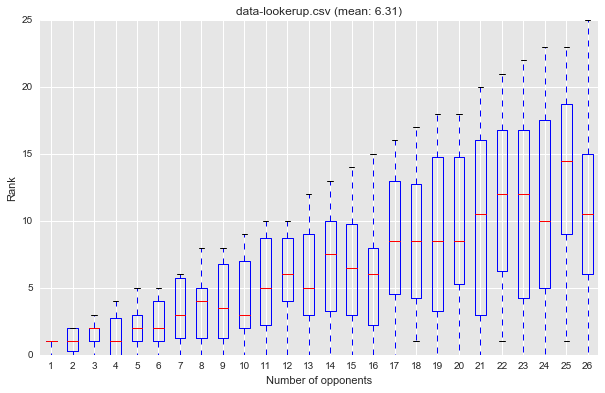

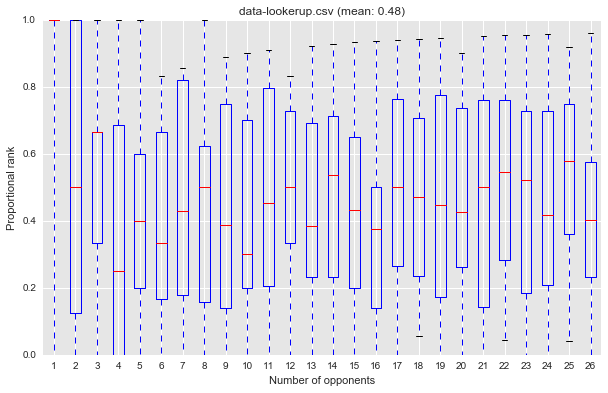

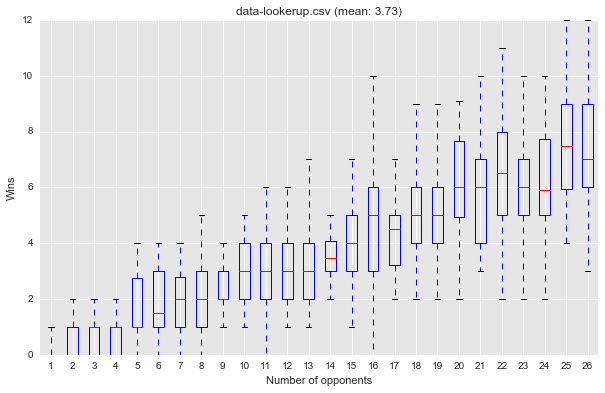

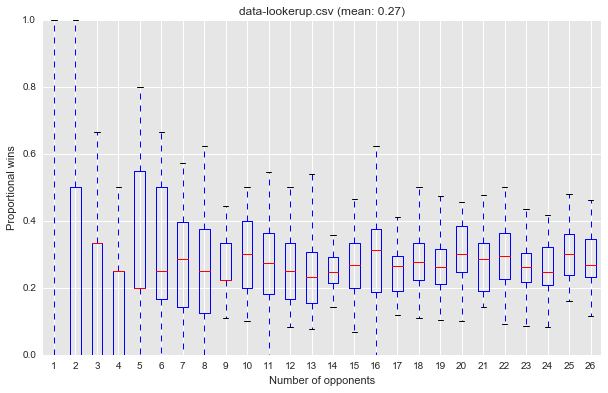

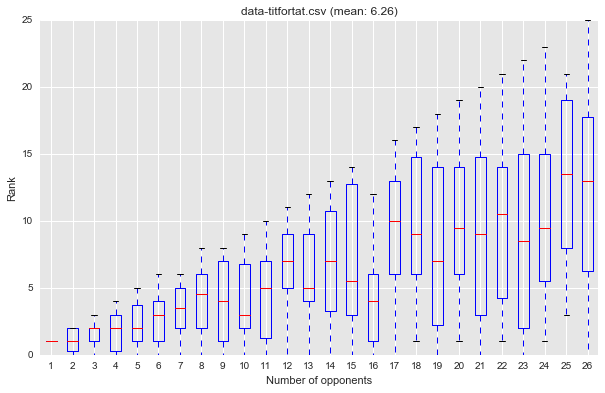

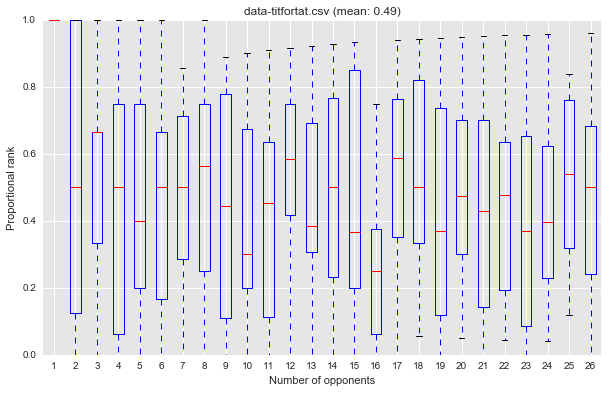

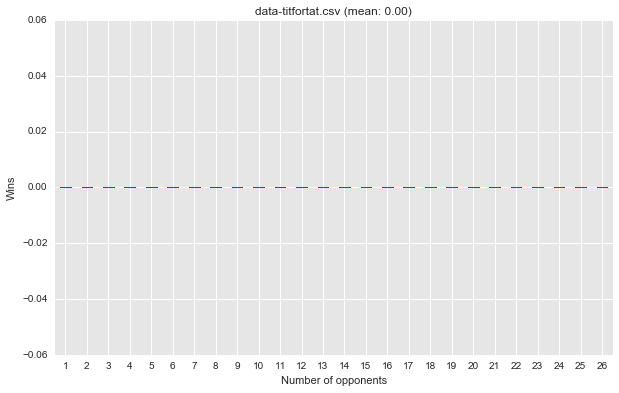

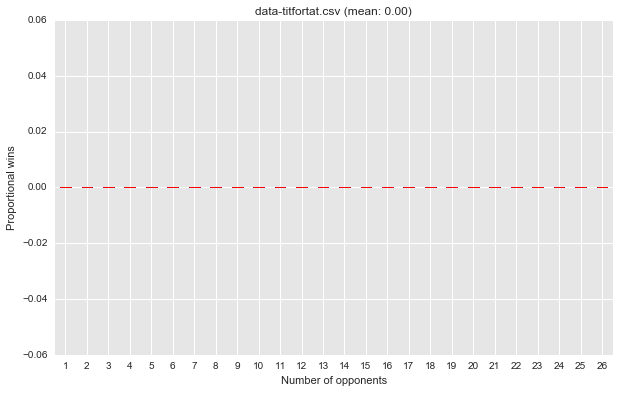

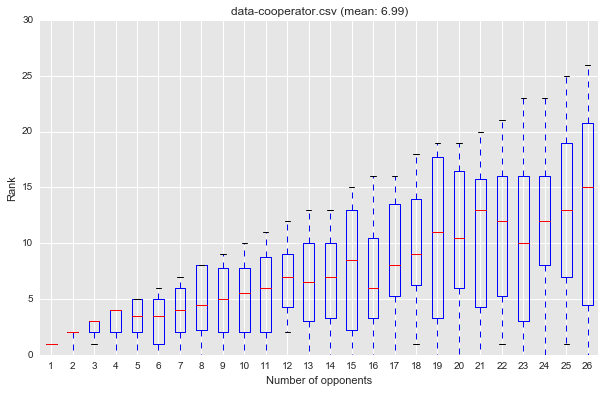

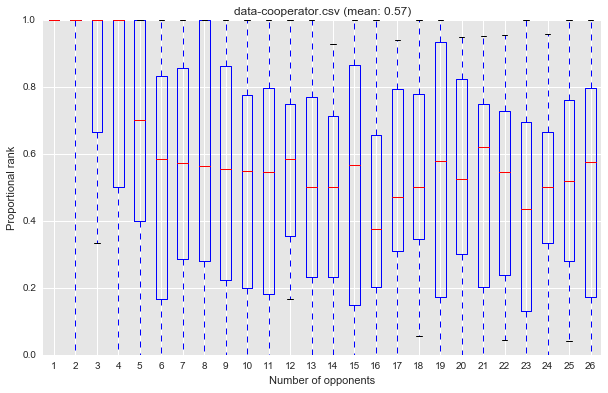

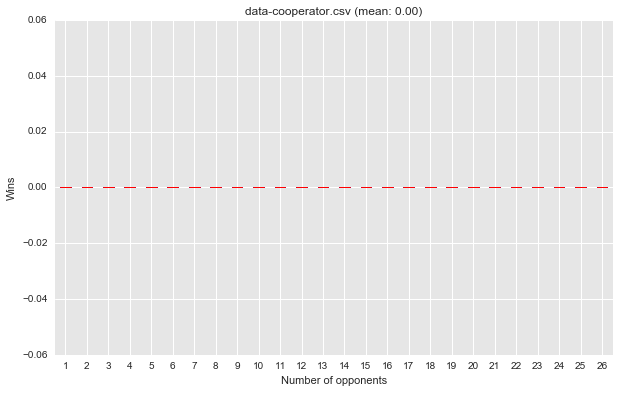

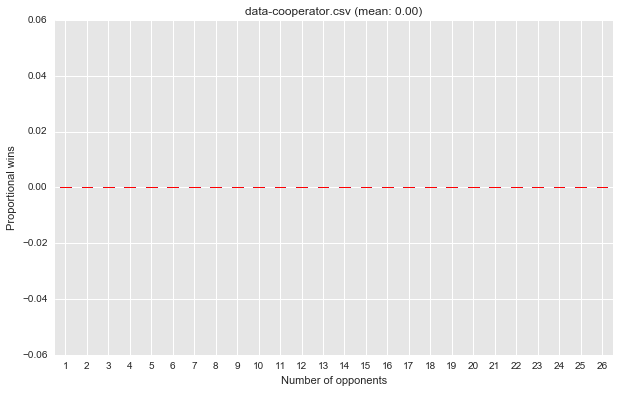

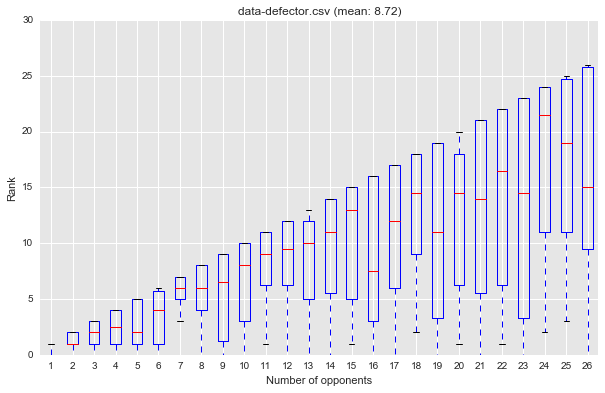

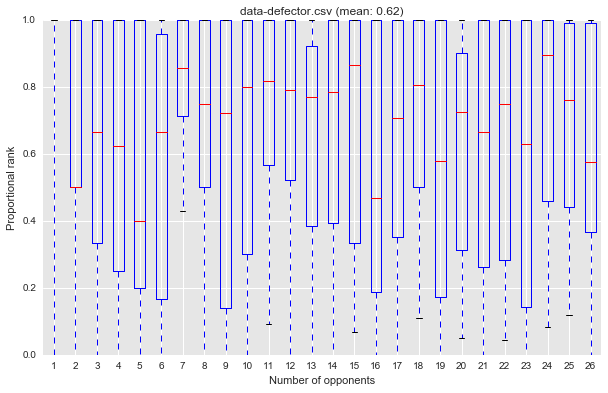

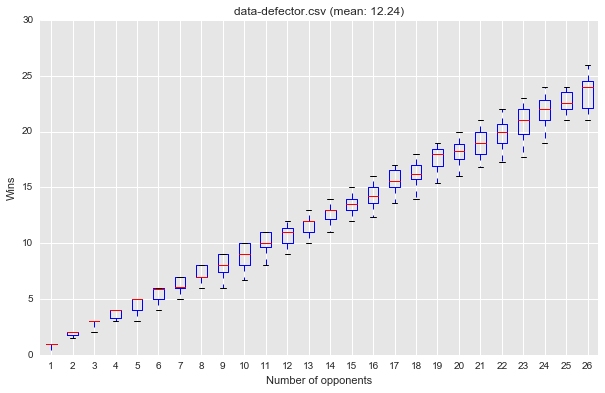

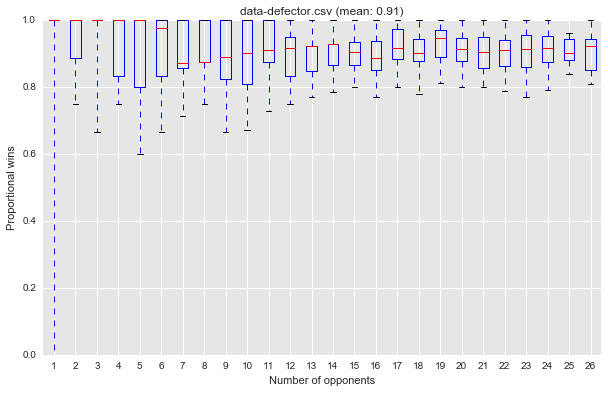

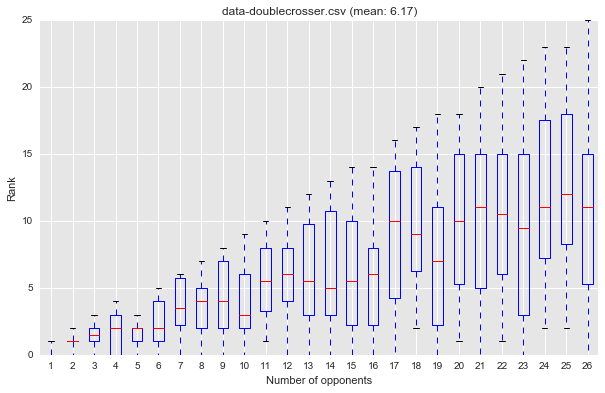

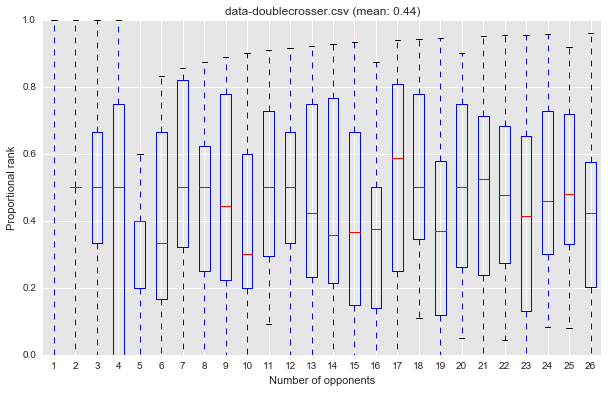

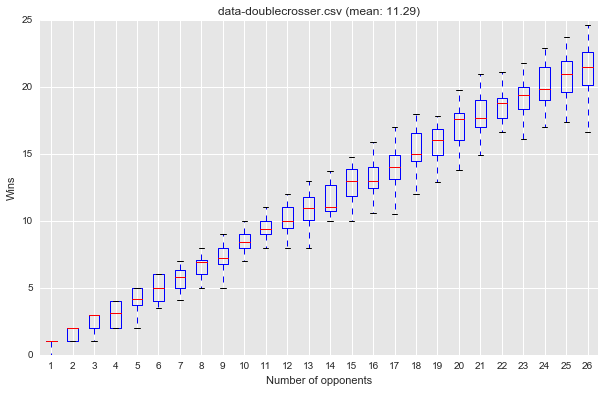

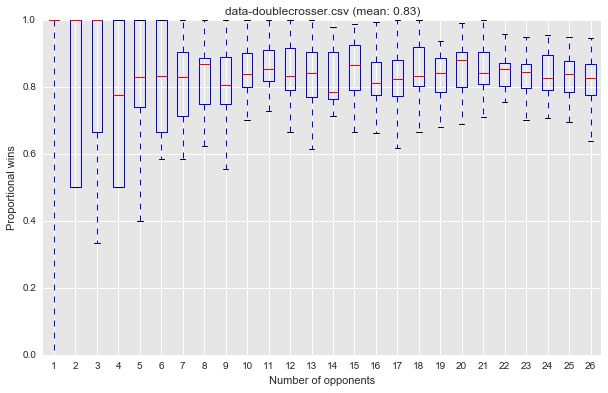

In [75]:
for data_file in ["data-lookerup.csv", "data-titfortat.csv", "data-cooperator.csv", "data-defector.csv", "data-doublecrosser.csv"]:
    read_data_and_plot(data_file)